In [41]:
#Installing & Loading Packages
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import ranksums

In [4]:
# Load the patient methylation profiles
m_log1k_path = "/u/home/c/ctang04/HBV_Code/data/data.log1k.txt"
donors_path = "/u/home/c/ctang04/HBV_Code/data/donors.with.samples.txt"

In [5]:
# Read methylation profile
m_log1k_df = pd.read_csv(m_log1k_path, sep='\t', header=0, index_col=0)
#print(m_log1k_df.columns)

# Read donors file
donors_df = pd.read_csv(donors_path, sep='\t', header=0, quotechar='"')

# Remove duplicate samples by donor
unique_donors_df = donors_df.drop_duplicates(subset='donor')

# Get phase classes from the donors
phases = unique_donors_df['phase_HBV'].unique()
print(phases)

# Define mapping between original phases and desired classes
phase_mapping = {
    "Antiviral Rx": "Antiviral Rx",
    "IAH": "IAH",
    "IT": "IT",
    "RP": "RP",
    "RP and Cirrhosis": "Cirrhosis",
    "Antiviral Rx and Cirrh": "Cirrhosis",
    "SC": "SC",
    "ICP": "ICP",
    "IAH and Cirrhosis": "Cirrhosis",
    "SC and Cirrhosis": "Cirrhosis"
}

# Create a new column in the dataframe with the modified classes
unique_donors_df.loc[:, 'modified_phase'] = unique_donors_df['phase_HBV'].map(phase_mapping)

['Antiviral Rx' 'IAH' 'IT' 'RP' 'RP and Cirrhosis'
 'Antiviral Rx and Cirrh' 'SC' 'ICP' 'IAH and Cirrhosis'
 'SC and Cirrhosis']


/u/local/apps/python/3.9.6/gcc-4.8.5/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [6]:
class_mapping = {
    "IT": "IT",
    "IAH": "IAH",
    "Antiviral Rx": "Other",
    "ICP": "Other",
    "RP": "RP",
    "Cirrhosis": "Other"
}
unique_donors_df.loc[:, 'modified_class'] = unique_donors_df['modified_phase'].map(class_mapping)

In [7]:
# Subset unique_donors_df for the IT class (9)
IT_class_df = unique_donors_df[unique_donors_df['modified_class'] == "IT"]

# Extract sample names
IT_sample_names = IT_class_df['sample'].tolist()

# Subset m_log1k_df based on Active_sample_names
IT_class_data = m_log1k_df.loc[:, IT_sample_names]

print(IT_class_data.shape)   # Displaying the dimensions (rows, columns)

(144560, 9)


In [8]:
# Subset unique_donors_df for the IAH (67)
IAH_class_df = unique_donors_df[unique_donors_df['modified_class'] == "IAH"]

# Extract sample names
IAH_sample_names = IAH_class_df['sample'].tolist()

# Subset m_log1k_df based on Active_sample_names
IAH_class_data = m_log1k_df.loc[:, IAH_sample_names]

print(IAH_class_data.shape)   # Displaying the dimensions (rows, columns)

(144560, 67)


In [9]:
# Subset unique_donors_df for the RP (33)
RP_class_df = unique_donors_df[unique_donors_df['modified_class'] == "RP"]

# Extract sample names
RP_sample_names = RP_class_df['sample'].tolist()

# Subset m_log1k_df based on Active_sample_names
RP_class_data = m_log1k_df.loc[:, RP_sample_names]

print(RP_class_data.shape)   # Displaying the dimensions (rows, columns)

(144560, 33)


In [10]:
# Transpose the DataFrames so that sample names are rows and methylation sites are columns
IT_class_data_t = IT_class_data.T
IAH_class_data_t = IAH_class_data.T
RP_class_data_t = RP_class_data.T

# Add a label column to each transposed DataFrame
IT_class_data_t['label'] = 0  # Label for IT
IAH_class_data_t['label'] = 1  # Label for IAH
RP_class_data_t['label'] = 2  # Label for RP

# Concatenate the transposed DataFrames along the rows (axis=0)
combined_df = pd.concat([IT_class_data_t, IAH_class_data_t, RP_class_data_t])

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Print shapes to verify dimensions
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y)

X_train shape: (87, 144560)
X_test shape: (22, 144560)
y_train shape: (87,)
y_test shape: (22,)
plasma-646-P9-CH             0
plasma-649-t8-6day-P9-CH     0
plasma-1626-P9-CH            0
plasma-3869-P9-CH            0
plasma-2457-P9-CH            0
                            ..
plasma-3409-P9-CH            2
plasma-2502-P9-CH            2
plasma-2738-P9-CH            2
plasma-2577-5day-P9-CH       2
plasma-2568-r1-4day-P9-CH    2
Name: label, Length: 109, dtype: int64


In [12]:
# Separate the active and inactive groups in the training data
X_train_IT = X_train[y_train == 0]
X_train_IAH = X_train[y_train == 1]
X_train_RP = X_train[y_train == 2]

print(X_train_IT.shape)
print(X_train_IAH.shape)
print(X_train_RP.shape)

(7, 144560)
(54, 144560)
(26, 144560)


In [11]:
#methylation_sites = X_train.columns
#print(methylation_sites.shape)
#print(X_train_active.shape)
#print(X_train_inactive.shape)

In [75]:

#X_train_IT 
#X_train_IAH 
#X_train_RP 
p_values_ITvIAH = []
X_train_active_IT = X_train_IT
X_train_inactive_IAH = X_train_IAH

methylation_sites = X_train.columns

for site in methylation_sites:
    active_values = X_train_active_IT[site].values
    inactive_values = X_train_inactive_IAH[site].values
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)  # Wilcoxon rank-sum test
    p_values_ITvIAH.append(p_val)
#print(len(p_values_ITvRest))

# Create a DataFrame for the results
results_df_ITvIAH = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_ITvIAH
})

significant_sites05_ITvIAH = results_df_ITvIAH[results_df_ITvIAH['p_value'] < 0.05]
significant_sites05_ITvIAH.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvIAH_p05_ttest.csv', index=False)
significant_sites01_ITvIAH = results_df_ITvIAH[results_df_ITvIAH['p_value'] < 0.01]
significant_sites01_ITvIAH.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvIAH_p01_ttest.csv', index=False)
# Print the significant sites
print(significant_sites05_ITvIAH.shape)
print(significant_sites01_ITvIAH.shape)


(10501, 2)
(4350, 2)


In [13]:
#X_train_IT 
#X_train_IAH 
#X_train_RP 
p_values_ITvRP = []
X_train_active_IT = X_train_IT
X_train_inactive_RP = X_train_RP

methylation_sites = X_train.columns

for site in methylation_sites:
    active_values = X_train_active_IT[site].values
    inactive_values = X_train_inactive_RP[site].values
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)  # Wilcoxon rank-sum test
    p_values_ITvRP.append(p_val)
#print(len(p_values_ITvRest))

# Create a DataFrame for the results
results_df_ITvRP = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_ITvRP
})

significant_sites05_ITvRP = results_df_ITvRP[results_df_ITvRP['p_value'] < 0.05]
significant_sites05_ITvRP.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvRP_p05_ttest.csv', index=False)
significant_sites01_ITvRP = results_df_ITvRP[results_df_ITvRP['p_value'] < 0.01]
significant_sites01_ITvRP.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvRP_p01_ttest.csv', index=False)
# Print the significant sites
print(significant_sites05_ITvRP.shape)
print(significant_sites01_ITvRP.shape)

(7239, 2)
(1901, 2)


In [14]:
p_values_RPvIAH = []
X_train_active_RP = X_train_RP
X_train_inactive_IAH = X_train_IAH

methylation_sites = X_train.columns

for site in methylation_sites:
    active_values = X_train_active_RP[site].values
    inactive_values = X_train_inactive_IAH[site].values
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)  # Wilcoxon rank-sum test
    p_values_RPvIAH.append(p_val)
#print(len(p_values_ITvRest))

# Create a DataFrame for the results
results_df_RPvIAH = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_RPvIAH
})

significant_sites05_RPvIAH = results_df_RPvIAH[results_df_RPvIAH['p_value'] < 0.05]
significant_sites05_RPvIAH.to_csv('/u/home/c/ctang04/HBV_Code/output/RPvIAH_p05_ttest.csv', index=False)
significant_sites01_RPvIAH = results_df_RPvIAH[results_df_RPvIAH['p_value'] < 0.01]
significant_sites01_RPvIAH.to_csv('/u/home/c/ctang04/HBV_Code/output/RPvIAH_p01_ttest.csv', index=False)
# Print the significant sites
print(significant_sites05_RPvIAH.shape)
print(significant_sites01_RPvIAH.shape)

(5138, 2)
(823, 2)


# P value and Fold Change

In [13]:
X_train_active_IT = X_train_IT
X_train_inactive_IAH = X_train_IAH

methylation_sites = X_train_IT.columns

p_values_ITvIAH = []
fold_changes_ITvIAH = []

for site in methylation_sites:
    active_values = X_train_active_IT[site].values
    inactive_values = X_train_inactive_IAH[site].values

    # Perform Welch's t-test
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)
    p_values_ITvIAH.append(p_val)

    # Calculate fold change
    pseudocount = 0.001
    mean_active = np.mean(active_values)
    mean_inactive = np.mean(inactive_values)
    
    if mean_inactive != 0:
        fold_change = np.log2((mean_active + pseudocount) / (mean_inactive + pseudocount))
    else:
        fold_change = float('NaN')  # Handle division by zero case

    fold_changes_ITvIAH.append(fold_change)

# Create a DataFrame for the results
results_df_ITvIAH = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_ITvIAH,
    'fold_change': fold_changes_ITvIAH
})

# Filter significant sites based on p-value thresholds
significant_sites05_ITvIAH = results_df_ITvIAH[results_df_ITvIAH['p_value'] < 0.05]
significant_sites05_ITvIAH.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvIAH_p05_ttest_fold_change.csv', index=False)
significant_sites01_ITvIAH = results_df_ITvIAH[results_df_ITvIAH['p_value'] < 0.01]
significant_sites01_ITvIAH.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvIAH_p01_ttest_fold_change.csv', index=False)

# Print the number of significant sites
print(significant_sites05_ITvIAH.shape)
print(significant_sites01_ITvIAH.shape)

(10501, 3)
(4350, 3)


In [14]:
X_train_active_IT = X_train_IT
X_train_inactive_RP = X_train_RP

methylation_sites = X_train_IT.columns

p_values_ITvRP = []
fold_changes_ITvRP = []

for site in methylation_sites:
    active_values = X_train_active_IT[site].values
    inactive_values = X_train_inactive_RP[site].values

    # Perform Welch's t-test
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)
    p_values_ITvRP.append(p_val)

    # Calculate fold change with pseudocount
    pseudocount = 0.001
    mean_active = np.mean(active_values)
    mean_inactive = np.mean(inactive_values)
    
    if mean_inactive != 0:
        fold_change = np.log2((mean_active + pseudocount) / (mean_inactive + pseudocount))
    else:
        fold_change = float('NaN')  # Handle division by zero case

    fold_changes_ITvRP.append(fold_change)

# Create a DataFrame for the results
results_df_ITvRP = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_ITvRP,
    'fold_change': fold_changes_ITvRP
})

# Filter significant sites based on p-value thresholds
significant_sites05_ITvRP = results_df_ITvRP[results_df_ITvRP['p_value'] < 0.05]
significant_sites05_ITvRP.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvRP_p05_ttest_fold_change.csv', index=False)
significant_sites01_ITvRP = results_df_ITvRP[results_df_ITvRP['p_value'] < 0.01]
significant_sites01_ITvRP.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvRP_p01_ttest_fold_change.csv', index=False)

# Print the number of significant sites
print(significant_sites05_ITvRP.shape)
print(significant_sites01_ITvRP.shape)

(7239, 3)
(1901, 3)


In [15]:
X_train_active_RP = X_train_RP
X_train_inactive_IAH = X_train_IAH

methylation_sites = X_train_RP.columns

p_values_RPvIAH = []
fold_changes_RPvIAH = []

for site in methylation_sites:
    active_values = X_train_active_RP[site].values
    inactive_values = X_train_inactive_IAH[site].values

    # Perform Welch's t-test
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)
    p_values_RPvIAH.append(p_val)

    # Calculate fold change with pseudocount
    pseudocount = 0.001
    mean_active = np.mean(active_values)
    mean_inactive = np.mean(inactive_values)
    
    if mean_inactive != 0:
        fold_change = np.log2((mean_active + pseudocount) / (mean_inactive + pseudocount))
    else:
        fold_change = float('NaN')  # Handle division by zero case

    fold_changes_RPvIAH.append(fold_change)

# Create a DataFrame for the results
results_df_RPvIAH = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_RPvIAH,
    'fold_change': fold_changes_RPvIAH
})

# Filter significant sites based on p-value thresholds
significant_sites05_RPvIAH = results_df_RPvIAH[results_df_RPvIAH['p_value'] < 0.05]
significant_sites05_RPvIAH.to_csv('/u/home/c/ctang04/HBV_Code/output/RPvIAH_p05_ttest_fold_change.csv', index=False)
significant_sites01_RPvIAH = results_df_RPvIAH[results_df_RPvIAH['p_value'] < 0.01]
significant_sites01_RPvIAH.to_csv('/u/home/c/ctang04/HBV_Code/output/RPvIAH_p01_ttest_fold_change.csv', index=False)

# Print the number of significant sites
print(significant_sites05_RPvIAH.shape)
print(significant_sites01_RPvIAH.shape)

(5138, 3)
(823, 3)


# Union

In [16]:
union_significant_sites05_1vRest = pd.concat([significant_sites05_ITvRP,significant_sites05_ITvIAH,significant_sites05_RPvIAH])
union_significant_sites05_1vRest.drop_duplicates().reset_index(drop=True)
print(union_significant_sites05_1vRest)

union_significant_sites01_1vRest = pd.concat([significant_sites01_ITvRP,significant_sites01_ITvIAH,significant_sites01_RPvIAH])
union_significant_sites01_1vRest.drop_duplicates().reset_index(drop=True)
print(union_significant_sites01_1vRest)

                 methylation_site   p_value  fold_change
16      chr10_100992139_100992258  0.007114    -9.256017
17      chr10_100992275_100992394  0.017237    -9.008365
18      chr10_100992374_100992493  0.017165    -8.966021
40      chr10_101089800_101089919  0.027449    -8.820565
41      chr10_101089922_101090041  0.002009    -9.626346
...                           ...       ...          ...
121216     chr6_90120915_90121034  0.044997    -6.636230
121515   chr7_132260465_132260584  0.025725     2.528339
122693   chr8_145911314_145911433  0.047533          NaN
122720     chr8_17658570_17658689  0.024195          NaN
123445   chr9_132199788_132199907  0.046934          NaN

[22878 rows x 3 columns]
                 methylation_site   p_value  fold_change
16      chr10_100992139_100992258  0.007114    -9.256017
41      chr10_101089922_101090041  0.002009    -9.626346
59      chr10_101287567_101287686  0.001957     0.583280
80      chr10_101294629_101294748  0.004394    -9.304916
111  

In [18]:
fold_change_threshold = 2
significant_sites_05_fold_change = union_significant_sites05_1vRest[union_significant_sites05_1vRest['fold_change'] > fold_change_threshold]
print(significant_sites_05_fold_change)

                 methylation_site   p_value  fold_change
10941   chr12_108238515_108238634  0.003872     2.071044
16192     chr13_20806709_20806828  0.032935     2.226247
16487     chr13_28368172_28368291  0.025739     2.391563
16720     chr13_30982804_30982923  0.031446     2.220010
23433     chr15_81073003_81073122  0.024460     2.403410
...                           ...       ...          ...
116112   chr2_219867615_219867734  0.038477     3.688468
118249     chr3_98451598_98451717  0.018071     4.225913
118250     chr3_98451691_98451810  0.005150     4.788858
119636     chr5_31855140_31855259  0.002411     4.677501
121515   chr7_132260465_132260584  0.025725     2.528339

[1061 rows x 3 columns]


In [35]:
significant_sites_05 = significant_sites_05_fold_change['methylation_site'].tolist()

# Select significant features from the training and testing data
X_train_significant = X_train[significant_sites_05]
X_test_significant = X_test[significant_sites_05]


print(X_train_significant.shape)
print(X_test_significant.shape)
print(y_train.shape)
print(y_test.shape)


(87, 1061)
(22, 1061)
(87,)
(22,)


In [36]:
#convert the dataframe to a np array
np_X_train_significant = X_train_significant.to_numpy()
np_X_test_significant = X_test_significant.to_numpy()
np_y_train = y_train.to_numpy()
np_y_test = y_test.to_numpy()

#prepare the DMatrix for training
dtrain = xgb.DMatrix(np_X_train_significant, label=y_train)
dtest = xgb.DMatrix(np_X_test_significant, label=y_test)

In [37]:
#param = {'objective': 'multi:softmax', 'num_class': 3} #, 'max_depth' : 4, 'lambda':0.4, 'eta' : 0.1
param = {'objective': 'multi:softmax', 'num_class': 3, 'max_depth' : 4, 'lambda':0.2, 'eta' : 0.1}
param['eval_metric'] = ['auc', 'mlogloss'] #merror

# Evaluation list
evallist = [(dtrain, 'train'), (dtest, 'eval')]

# Number of boosting rounds
num_round = 20

# Training the model
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-auc:0.99930	train-mlogloss:0.97348	eval-auc:0.54823	eval-mlogloss:1.04746
[1]	train-auc:1.00000	train-mlogloss:0.86547	eval-auc:0.54318	eval-mlogloss:1.01521
[2]	train-auc:1.00000	train-mlogloss:0.77481	eval-auc:0.44962	eval-mlogloss:0.99617
[3]	train-auc:1.00000	train-mlogloss:0.69616	eval-auc:0.46755	eval-mlogloss:0.98427
[4]	train-auc:1.00000	train-mlogloss:0.62775	eval-auc:0.48295	eval-mlogloss:0.97569
[5]	train-auc:1.00000	train-mlogloss:0.56631	eval-auc:0.48295	eval-mlogloss:0.96465
[6]	train-auc:1.00000	train-mlogloss:0.51034	eval-auc:0.49848	eval-mlogloss:0.96273
[7]	train-auc:1.00000	train-mlogloss:0.46284	eval-auc:0.52563	eval-mlogloss:0.95791
[8]	train-auc:1.00000	train-mlogloss:0.42042	eval-auc:0.54167	eval-mlogloss:0.95029
[9]	train-auc:1.00000	train-mlogloss:0.38048	eval-auc:0.54773	eval-mlogloss:0.94918
[10]	train-auc:1.00000	train-mlogloss:0.34540	eval-auc:0.55051	eval-mlogloss:0.95442
[11]	train-auc:1.00000	train-mlogloss:0.31535	eval-auc:0.55556	eval-mloglos

/u/home/c/ctang04/.local/lib/python3.9/site-packages/xgboost/core.py:735: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


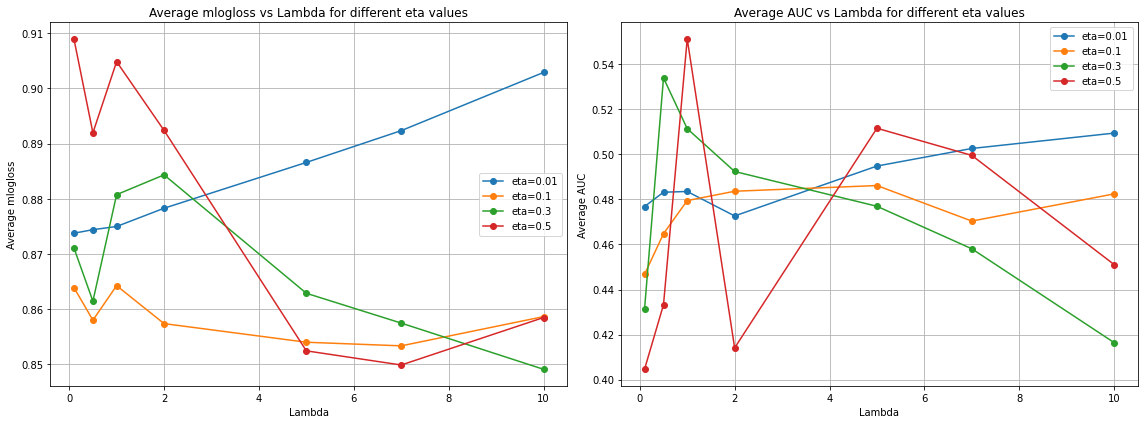

Lambda: 0.1, eta: 0.01, Average mlogloss: 0.873774131762436, Average AUC: 0.4768213268213268
Lambda: 0.1, eta: 0.1, Average mlogloss: 0.8639360288194581, Average AUC: 0.4467032967032967
Lambda: 0.1, eta: 0.3, Average mlogloss: 0.8711098468965954, Average AUC: 0.4312576312576312
Lambda: 0.1, eta: 0.5, Average mlogloss: 0.9089657060071534, Average AUC: 0.40459910459910464
Lambda: 0.5, eta: 0.01, Average mlogloss: 0.8744125766302245, Average AUC: 0.48317053317053316
Lambda: 0.5, eta: 0.1, Average mlogloss: 0.8580231561672453, Average AUC: 0.46477411477411473
Lambda: 0.5, eta: 0.3, Average mlogloss: 0.8614652808000839, Average AUC: 0.5339031339031339
Lambda: 0.5, eta: 0.5, Average mlogloss: 0.8919574740275837, Average AUC: 0.43324684574684574
Lambda: 1.0, eta: 0.01, Average mlogloss: 0.8749920708876031, Average AUC: 0.48349613349613346
Lambda: 1.0, eta: 0.1, Average mlogloss: 0.8642769051143547, Average AUC: 0.4794566544566545
Lambda: 1.0, eta: 0.3, Average mlogloss: 0.880762327574437, Ave

In [42]:
from sklearn.preprocessing import label_binarize
# Binarize the test labels for AUC calculation
y_bin_test = label_binarize(y_test, classes=[0, 1, 2])

# Set fixed parameters
fixed_params = {
    'objective': 'multi:softprob',  # Change to 'multi:softprob' for probability outputs
    'num_class': 3,
    'max_depth': 4,
    'alpha': 1,
    'eval_metric': 'mlogloss'  # Using mlogloss as the evaluation metric
}

# Define range of lambda and eta values to test
lambda_values = [0.1, 0.5, 1.0, 2.0, 5.0, 7.0, 10.0]
eta_values = [0.01, 0.1, 0.3, 0.5]

# Store average mlogloss and AUC for each lambda and eta value
results = []

# Perform grid search for each lambda and eta combination
for lam in lambda_values:
    for eta in eta_values:
        params = fixed_params.copy()
        params['lambda'] = lam
        params['eta'] = eta

        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=100,
            nfold=5,  # Number of cross-validation folds
            early_stopping_rounds=10,
            seed=42
        )

        # Get the mean mlogloss from the cross-validation results
        mean_mlogloss = cv_results['test-mlogloss-mean'].min()

        # Train the model and compute AUC on the test set
        model = xgb.train(params, dtrain, num_boost_round=len(cv_results))
        y_pred_proba = model.predict(dtest)
        auc = roc_auc_score(y_bin_test, y_pred_proba, multi_class='ovr')

        # Store results
        results.append({
            'lambda': lam,
            'eta': eta,
            'average_mlogloss': mean_mlogloss,
            'average_auc': auc
        })

# Extract results for plotting
lambda_eta_pairs = [(res['lambda'], res['eta']) for res in results]
average_mlogloss = [res['average_mlogloss'] for res in results]
average_auc = [res['average_auc'] for res in results]

# Plot the results
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for eta in eta_values:
    plt.plot(lambda_values, [res['average_mlogloss'] for res in results if res['eta'] == eta], marker='o', label=f'eta={eta}')
plt.xlabel('Lambda')
plt.ylabel('Average mlogloss')
plt.title('Average mlogloss vs Lambda for different eta values')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for eta in eta_values:
    plt.plot(lambda_values, [res['average_auc'] for res in results if res['eta'] == eta], marker='o', label=f'eta={eta}')
plt.xlabel('Lambda')
plt.ylabel('Average AUC')
plt.title('Average AUC vs Lambda for different eta values')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the results
for res in results:
    print(f"Lambda: {res['lambda']}, eta: {res['eta']}, Average mlogloss: {res['average_mlogloss']}, Average AUC: {res['average_auc']}")

In [54]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, seed=42, max_depth= 3, reg_lambda = 0.5, eta = 0.3)
model.fit(np_X_train_significant, y_train)
y_pred = model.predict(np_X_test_significant)

In [53]:
y_pred_proba = model.predict_proba(np_X_test_significant)
#Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate ROC AUC score for each class
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f'ROC AUC Score: {roc_auc:.2f}')

Accuracy: 0.59
ROC AUC Score: 0.49


In [48]:
#Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate ROC AUC score for each class
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f'ROC AUC Score: {roc_auc:.2f}')

Accuracy: 0.64
ROC AUC Score: 0.52


In [55]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate sensitivity (recall) for each class
sensitivity = np.diag(cm) / np.sum(cm, axis=1)

# Calculate specificity for each class
specificity = []
for i in range(cm.shape[0]):
    # True negatives (TN) for class i
    TN = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    # False positives (FP) and true negatives (TN) for class i
    FP_plus_TN = np.sum(cm) - np.sum(cm[:, i])
    # Specificity for class i
    if FP_plus_TN == 0:
        specificity_i = 0
    else:
        specificity_i = TN / FP_plus_TN
    specificity.append(specificity_i)

# Print results for sensitivity and specificity
for i in range(cm.shape[0]):
    print(f'Class {i}: Sensitivity (Recall) = {sensitivity[i]:.2f}, Specificity = {specificity[i]:.2f}')

[[ 0  2  0]
 [ 0 11  2]
 [ 0  4  3]]
Class 0: Sensitivity (Recall) = 0.00, Specificity = 0.91
Class 1: Sensitivity (Recall) = 0.85, Specificity = 0.60
Class 2: Sensitivity (Recall) = 0.43, Specificity = 0.76


In [60]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, seed=42, max_depth= 4, reg_lambda = 0.2, eta = 0.1)
model.fit(np_X_train_significant, y_train)
y_pred = model.predict(np_X_test_significant)
y_pred_proba = model.predict_proba(np_X_test_significant)
#Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate ROC AUC score for each class
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f'ROC AUC Score: {roc_auc:.2f}')

Accuracy: 0.59
ROC AUC Score: 0.48


In [61]:
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, seed=42, max_depth= 3, reg_lambda = 0.2, eta = 0.1)
model.fit(np_X_train_significant, y_train)
y_pred = model.predict(np_X_test_significant)
y_pred_proba = model.predict_proba(np_X_test_significant)
#Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate ROC AUC score for each class
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f'ROC AUC Score: {roc_auc:.2f}')

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate sensitivity (recall) for each class
sensitivity = np.diag(cm) / np.sum(cm, axis=1)

# Calculate specificity for each class
specificity = []
for i in range(cm.shape[0]):
    # True negatives (TN) for class i
    TN = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    # False positives (FP) and true negatives (TN) for class i
    FP_plus_TN = np.sum(cm) - np.sum(cm[:, i])
    # Specificity for class i
    if FP_plus_TN == 0:
        specificity_i = 0
    else:
        specificity_i = TN / FP_plus_TN
    specificity.append(specificity_i)

# Print results for sensitivity and specificity
for i in range(cm.shape[0]):
    print(f'Class {i}: Sensitivity (Recall) = {sensitivity[i]:.2f}, Specificity = {specificity[i]:.2f}')

Accuracy: 0.59
ROC AUC Score: 0.54
[[ 0  2  0]
 [ 0 10  3]
 [ 0  4  3]]
Class 0: Sensitivity (Recall) = 0.00, Specificity = 0.91
Class 1: Sensitivity (Recall) = 0.77, Specificity = 0.50
Class 2: Sensitivity (Recall) = 0.43, Specificity = 0.75
